In [1]:
#run from the root directory
import os

os.chdir("..")

In [2]:
configs = [file for file in os.listdir("./results/") if file.endswith(".pkl") and 'baseline' not in file]

In [3]:
import random
import numpy as np
import pickle as pkl
from collections import defaultdict
from sklearn.metrics import (
    precision_recall_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
import matplotlib.pyplot as plt
from config import *

def compute(labels, preds):
    return { 'accuracy': accuracy_score(labels, preds),
            'precision': precision_score(labels, preds),
            'recall': recall_score(labels, preds),
            'f1_score': f1_score(labels, preds)
    }

def findMean(data):
    _result = {}
    for key in data.keys():
        val = data[key]
        val = np.array(val).astype(np.float32)
        mean = np.round(np.mean(val), 3)
        std = np.round(np.std(val), 3)
        _result[key] = str(mean) + u" \u00B1 " + str(std)
    return _result


def calculate_accuracy(labels, predictions, threshold):
    binary_predictions = (predictions >= threshold).astype(int)
    correct_predictions = (binary_predictions == labels).sum()
    return correct_predictions / len(labels)

def evaluate(data):
    labels = data['label']
    preds = data['prediction']

    cresult = defaultdict(list)

    for seed in range(10):
        random.seed(seed)
        zlist = list(zip(labels, preds))
        random.shuffle(zlist)

        val_size = int(0.1 * len(zlist))
        val_zlist = zlist[0:val_size]
        test_zlist = zlist[val_size:]

        vlabels, vpreds = zip(*val_zlist)
        tlabels, tpreds = zip(*test_zlist)


        # precision, recall, threshold = precision_recall_curve(vlabels, vpreds)
        # f1_scores = 2*recall*precision/(recall+precision + 1e-8)

        # Sweep over thresholds
        thresholds = np.linspace(0, 1, 101)
        best_accuracy = 0
        best_threshold = 0

        for threshold in thresholds:
            accuracy = calculate_accuracy(vlabels, vpreds, threshold)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = threshold

        # cutoff = threshold[np.argmax(f1_scores)]
        cutoff = best_threshold

        rpreds = 1.0 * np.array([x > cutoff for x in tpreds])
        _result = compute(tlabels, rpreds)
        _result['auc_roc_score'] = roc_auc_score(tlabels, tpreds)
        _result['cutoff'] = cutoff

        for key in _result.keys():
            cresult[key].append(_result[key])
    
    return findMean(cresult)



In [122]:
presults = defaultdict(lambda: defaultdict(dict))

data = pkl.load(open(f"./results/bert.pkl", "rb"))

for domain in data.keys():
    presults[domain] = evaluate(data[domain])


In [ ]:
data = presults

import csv
csv_rows = []

# Prepare headers
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc_score', 'cutoff']
empty_cell = len(metrics) - 1

headers_main = [""] + metrics
csv_rows.append(headers_main)

# Prepare rows by category
domains = list(data.keys())
for domain in domains:
    row = [domain]
    for metric in metrics:
        row.append(data[domain][metric])
    csv_rows.append(row)

# Write to CSV
with open("BERToutput.csv", "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_rows)


In [60]:
presults = defaultdict(lambda: defaultdict(dict))

for config in configs:
    data = pkl.load(open(f"./results/{config}", "rb"))
    config_name = str(config)[:-4]
    print(config_name)
    
    for domain in data.keys():
        presults[config_name][domain] = evaluate(data[domain])


individual_32


In [61]:
data = presults
data = dict(sorted(data.items(), key=lambda item: int(item[0].split('_')[1])))
data

{'individual_32': defaultdict(dict,
             {'Discrimination, Exclusion, Toxicity': {'accuracy': '0.901 ± 0.002',
               'precision': '0.896 ± 0.028',
               'recall': '0.906 ± 0.031',
               'f1_score': '0.9 ± 0.002',
               'auc_roc_score': '0.974 ± 0.001',
               'cutoff': '0.376 ± 0.093'},
              'HCI harms': {'accuracy': '0.951 ± 0.004',
               'precision': '0.943 ± 0.015',
               'recall': '0.961 ± 0.009',
               'f1_score': '0.952 ± 0.004',
               'auc_roc_score': '0.989 ± 0.0',
               'cutoff': '0.184 ± 0.069'},
              'Malicious Uses': {'accuracy': '0.823 ± 0.003',
               'precision': '0.832 ± 0.036',
               'recall': '0.815 ± 0.055',
               'f1_score': '0.821 ± 0.011',
               'auc_roc_score': '0.908 ± 0.002',
               'cutoff': '0.404 ± 0.092'},
              'Misinformation': {'accuracy': '0.898 ± 0.008',
               'precision': '0.92 ±

In [6]:
import csv
csv_rows = []

# Prepare headers
headers_main = ["Category"]
# headers_sub = [""]
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc_score', 'cutoff']
empty_cell = len(metrics) - 1

for individual in data.keys():
    # headers_main.append(individual)
    # headers_main.extend([""]*empty_cell)
    individual_metrics = [individual + "_" + metric for metric in metrics]
    headers_main.extend(individual_metrics)
    # headers_sub.extend(individual_metrics)

csv_rows.append(headers_main)
# csv_rows.append(headers_sub)

# Prepare rows by category
categories = list(data['individual_20'].keys())
for category in categories:
    row = [category]
    for individual in data.keys():
        for metric in metrics:
            row.append(data[individual][category][metric])
    csv_rows.append(row)

# Write to CSV
with open("output.csv", "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_rows)


KeyError: 'individual_20'

## Analyze the results

In [4]:
import pandas as pd
df = pd.read_csv("output.csv")
df = df.T
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df.reset_index(inplace=True)
df.rename(columns={'index': 'Category'}, inplace=True)

In [5]:
dq = df[df["Category"].str.contains("accuracy", case=True)]
layers = list(dq["Category"].map(lambda x: x.split("_")[1]))
values = [list(dq["HCI harms"]), list(dq["Discrimination, Exclusion, Toxicity"]), list(dq["Malicious Uses"]), list(dq["Misinformation"])]
print(values)
for val in values:
    for x in range(len(val)):
        val[x] = float(val[x].split('±')[0])

np.mean(np.array(values), axis=0)

[['0.682 ± 0.002', '0.689 ± 0.002', '0.664 ± 0.002', '0.666 ± 0.003', '0.676 ± 0.002', '0.687 ± 0.002', '0.694 ± 0.002', '0.649 ± 0.002', '0.657 ± 0.003'], ['0.558 ± 0.002', '0.641 ± 0.002', '0.726 ± 0.001', '0.835 ± 0.002', '0.831 ± 0.001', '0.828 ± 0.001', '0.786 ± 0.002', '0.828 ± 0.002', '0.833 ± 0.002'], ['0.543 ± 0.002', '0.538 ± 0.003', '0.553 ± 0.007', '0.566 ± 0.004', '0.577 ± 0.002', '0.558 ± 0.003', '0.554 ± 0.003', '0.549 ± 0.006', '0.565 ± 0.003'], ['0.696 ± 0.003', '0.66 ± 0.002', '0.67 ± 0.001', '0.623 ± 0.003', '0.62 ± 0.002', '0.627 ± 0.002', '0.644 ± 0.002', '0.637 ± 0.001', '0.655 ± 0.002']]


array([0.61975, 0.632  , 0.65325, 0.6725 , 0.676  , 0.675  , 0.6695 ,
       0.66575, 0.6775 ])

In [6]:
dq

Category,Category,"Discrimination, Exclusion, Toxicity",HCI harms,Malicious Uses,Misinformation
0,individual_1_accuracy,0.558 ± 0.002,0.682 ± 0.002,0.543 ± 0.002,0.696 ± 0.003
6,individual_4_accuracy,0.641 ± 0.002,0.689 ± 0.002,0.538 ± 0.003,0.66 ± 0.002
12,individual_8_accuracy,0.726 ± 0.001,0.664 ± 0.002,0.553 ± 0.007,0.67 ± 0.001
18,individual_12_accuracy,0.835 ± 0.002,0.666 ± 0.003,0.566 ± 0.004,0.623 ± 0.003
24,individual_16_accuracy,0.831 ± 0.001,0.676 ± 0.002,0.577 ± 0.002,0.62 ± 0.002
30,individual_20_accuracy,0.828 ± 0.001,0.687 ± 0.002,0.558 ± 0.003,0.627 ± 0.002
36,individual_24_accuracy,0.786 ± 0.002,0.694 ± 0.002,0.554 ± 0.003,0.644 ± 0.002
42,individual_28_accuracy,0.828 ± 0.002,0.649 ± 0.002,0.549 ± 0.006,0.637 ± 0.001
48,individual_32_accuracy,0.833 ± 0.002,0.657 ± 0.003,0.565 ± 0.003,0.655 ± 0.002


In [7]:
import pandas as pd
df1 = pd.read_csv("./output/BERToutput.csv")

df1.columns = ['Domain', 'accuracy', 'precision', 'recall', 'f1_score',
       'auc_roc_score', 'cutoff']

bert_accuracy = {}

for index, row in df1.iterrows():
    bert_accuracy[row['Domain']] = float(row['accuracy'].split('±')[0])

bert_accuracy

{'Discrimination, Exclusion, Toxicity': 0.599,
 'Misinformation': 0.609,
 'HCI harms': 0.556,
 'Malicious Uses': 0.607}

In [9]:
65.5-61

4.5

In [24]:
for feat in ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc_score']:
   dq = df[df["Category"].str.contains(feat, case=True)]
   layers = list(dq["Category"].map(lambda x: x.split("_")[1]))
   values = [list(dq["HCI harms"]), list(dq["Discrimination, Exclusion, Toxicity"]), list(dq["Malicious Uses"]), list(dq["Misinformation"])]

   for val in values:
      for x in range(len(val)):
         val[x] = float(val[x].split('±')[0])

   llama = np.mean(np.array(values), axis=0) 
   llama = [llama[0], llama[2], llama[4], llama[6], llama[8]]

   bert_accuracy = {}

   for index, row in df1.iterrows():
      bert_accuracy[row['Domain']] = float(row[feat].split('±')[0])

   bert = np.mean(list(bert_accuracy.values()))

   print(feat, bert, llama)

accuracy 0.59275 [0.61975, 0.65325, 0.676, 0.6695, 0.6775]
precision 0.592 [0.66925, 0.73275, 0.72575, 0.72075, 0.72375]
recall 0.6094999999999999 [0.5437500000000001, 0.50625, 0.60875, 0.58875, 0.595]
f1_score 0.5912499999999999 [0.58325, 0.58175, 0.6315000000000001, 0.6192500000000001, 0.63]
auc_roc_score 0.61625 [0.648, 0.6864999999999999, 0.7082499999999999, 0.6859999999999999, 0.70775]


In [87]:
t1 = [0.657, 0.833, 0.565, 0.655]

[0.657, 0.833, 0.565, 0.655]

In [90]:
[a1, a2, a3]

[[0.599, 0.609, 0.556, 0.607],
 [0.856, 0.801, 0.887, 0.7],
 [1.0, 1.0, 1.0, 1.0]]

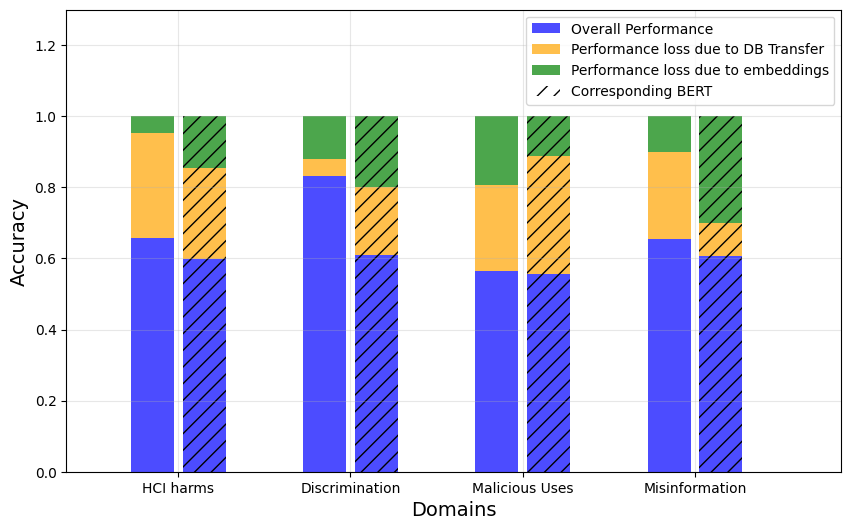

In [51]:
import seaborn as sns
values = np.array(values)

t1 = values[:, -1].tolist()
t1 = [0.657, 0.833, 0.565, 0.655]
t2 = [0.952, 0.879, 0.806, 0.900]
t3 = [1.0, 1.0, 1.0, 1.0]
d2 = [y - x for (x,y) in zip(t1, t2)]
d3 = [y - x for (x,y) in zip(t2, t3)]

a1 = [0.599, 0.609, 0.556, 0.607]
a2 = [0.856, 0.801, 0.887, 0.7]
a3 = [1.0, 1.0, 1.0, 1.0]
b2 = [y - x for (x,y) in zip(a1, a2)]
b3 = [y - x for (x,y) in zip(a2, a3)]

# indices = DOMAINS
indices = np.arange(0, 4, 1)
bar_width = 0.25

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha='center')

plt.figure(figsize=(10, 6))
plt.grid(alpha=0.3)
plt.bar(indices, t1, bar_width, color='b', label='Overall Performance', alpha=0.7)
# addlabels(indices, np.round([x for x in t1], 2))
plt.bar(indices, d2, bar_width, bottom=t1, color='orange', label='Performance loss due to DB Transfer', alpha=0.7)
# addlabels(indices, np.round([x for x in t2], 2))
plt.bar(indices, d3, bar_width, bottom=t2, color='g', label = 'Performance loss due to embeddings', alpha=0.7)

plt.bar(indices + 0.3 , a1, bar_width,  color='b', hatch='//', alpha=0.7)
plt.bar(indices + 0.3 , b2, bar_width, bottom=a1, color='orange',hatch='//', alpha=0.7)
plt.bar(indices + 0.3 , b3, bar_width, bottom=a2, color='g', hatch='//', alpha=0.7)
plt.bar(100 , b3, bar_width, bottom=a2, color='white', hatch='//', alpha=0.7, label='Corresponding BERT')

plt.xticks(indices + 0.15, ('HCI harms', 'Discrimination', 'Malicious Uses', 'Misinformation'))
plt.legend()
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Domains', fontsize=14)
plt.ylim(0, 1.3)
plt.xlim(-0.5,4)
plt.show()

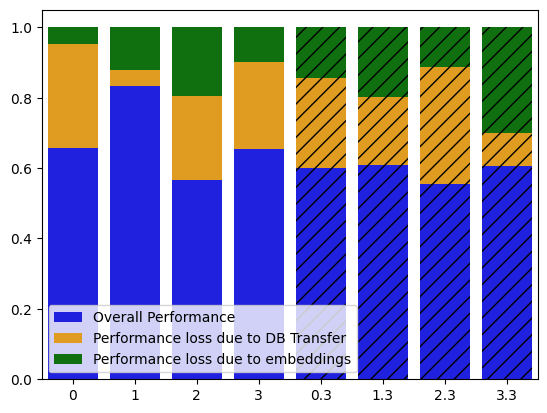

In [92]:
import seaborn as sns
values = np.array(values)

t1 = values[:, -1].tolist()
t1 = [0.657, 0.833, 0.565, 0.655]
t2 = [0.952, 0.879, 0.806, 0.900]
t3 = [1.0, 1.0, 1.0, 1.0]
d2 = [y - x for (x,y) in zip(t1, t2)]
d3 = [y - x for (x,y) in zip(t2, t3)]

a1 = [0.599, 0.609, 0.556, 0.607]
a2 = [0.856, 0.801, 0.887, 0.7]
a3 = [1.0, 1.0, 1.0, 1.0]
b2 = [y - x for (x,y) in zip(a1, a2)]
b3 = [y - x for (x,y) in zip(a2, a3)]

# indices = DOMAINS
indices = np.arange(0, 4, 1)
bar_width = 0.25

sns.barplot(x=indices, y=t1, color='b', label='Overall Performance')
sns.barplot(x=indices, y=d2, bottom=t1, color='orange', label='Performance loss due to DB Transfer')
sns.barplot(x=indices, y=d3, bottom=t2, color='g', label = 'Performance loss due to embeddings')

sns.barplot(x=indices + 0.3 , y=a1, color='b', hatch='//')
sns.barplot(x=indices + 0.3 , y=b2, bottom=a1, color='orange',hatch='//')
sns.barplot(x=indices + 0.3 , y=b3, bottom=a2, color='g', hatch='//')

plt.show()

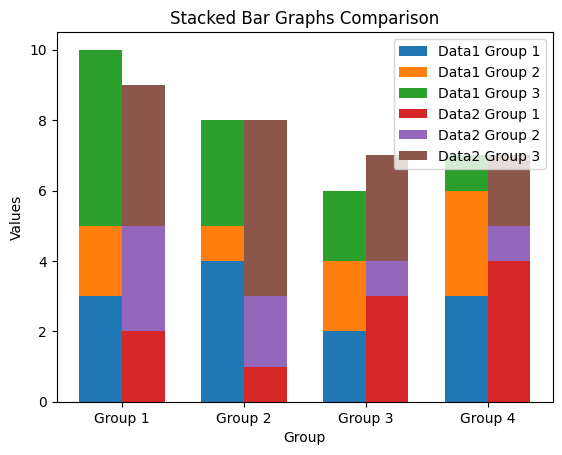

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
# Data for two bar graphs (each with 3 stacked values)
data1 = np.array([[3, 2, 5], [4, 1, 3], [2, 2, 2], [3, 3, 1]])
data2 = np.array([[2, 3, 4], [1, 2, 5], [3, 1, 3], [4, 1, 2]])

n_groups = 4
bar_width = 0.35
index = np.arange(n_groups)

# Plotting
fig, ax = plt.subplots()

# First bar graph
for i in range(data1.shape[1]):
    ax.bar(index, data1[:, i], bar_width, bottom=np.sum(data1[:, :i], axis=1), label=f'Data1 Group {i+1}')

# Second bar graph (offset by bar_width)
for i in range(data2.shape[1]):
    ax.bar(index + bar_width, data2[:, i], bar_width, bottom=np.sum(data2[:, :i], axis=1), label=f'Data2 Group {i+1}')

# Adding labels and title
ax.set_xlabel('Group')
ax.set_ylabel('Values')
ax.set_title('Stacked Bar Graphs Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'Group {i+1}' for i in range(n_groups)])
ax.legend()

# Display the plot
plt.show()


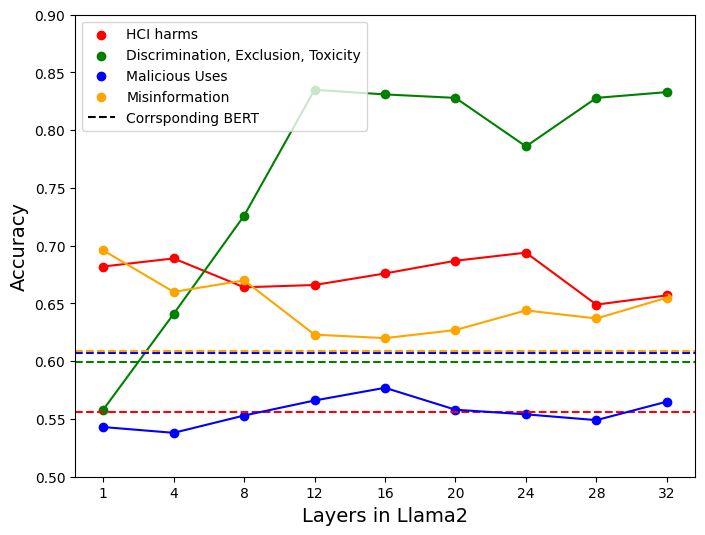

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
ll = ["HCI harms", "Discrimination, Exclusion, Toxicity", "Malicious Uses", "Misinformation"]
domain2color = {"HCI harms": "red", "Discrimination, Exclusion, Toxicity": "green", "Malicious Uses": "blue", "Misinformation": "orange"}
for i, val in enumerate(values):
    plt.scatter(layers, val, label=ll[i], c=domain2color[ll[i]])
    plt.plot(layers, val, c=domain2color[ll[i]])
    plt.axhline(y=bert_accuracy[ll[i]], color=domain2color[ll[i]], linestyle='--')

plt.axhline(y=0.40, color='black', linestyle='--', label='Corrsponding BERT')
plt.ylim(0.5, 0.90)
plt.xlabel("Layers in Llama2", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend()
plt.show()

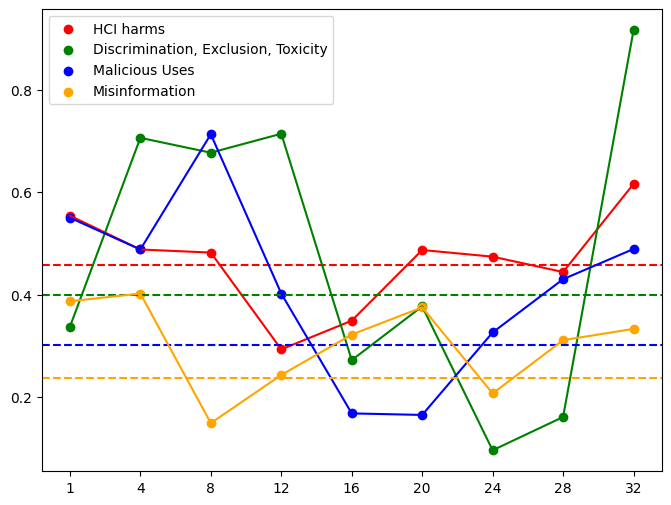

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
ll = ["HCI harms", "Discrimination, Exclusion, Toxicity", "Malicious Uses", "Misinformation"]
domain2color = {"HCI harms": "red", "Discrimination, Exclusion, Toxicity": "green", "Malicious Uses": "blue", "Misinformation": "orange"}
for i, val in enumerate(values):
    plt.scatter(layers, val, label=ll[i], c=domain2color[ll[i]])
    plt.plot(layers, val, c=domain2color[ll[i]])
    plt.axhline(y=bert_accuracy[ll[i]], color=domain2color[ll[i]], linestyle='--')
plt.legend()
plt.show()

In [43]:
import torch.nn as nn
class SafetyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # self.hidden_1 = nn.Linear(4096, 1024)
        # self.relu = nn.ReLU()
        # self.hidden_2 = nn.Linear(1024, 256)
        # self.hidden_3 = nn.Linear(256, 32)
        # self.output = nn.Linear(32, 1)
        self.output = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, batch):
      batch = [x.to(DEVICE) for x in batch]
      x, labels = batch
    #   x = self.relu(self.hidden_1(x))
    #   x = self.relu(self.hidden_2(x))
    #   x = self.relu(self.hidden_3(x))
      x = self.sigmoid(self.output(x))
      return x, labels
    def predict(self, data):
       x = torch.tensor(data, dtype=torch.float32).cuda()
       x = self.sigmoid(self.output(x))
       x = x.detach().cpu().numpy().squeeze()
       return x

In [79]:
import torch

ll = []
for i in range(4):
   _model = torch.load(f"./network_weights/individual_4_{DOMAINS[i]}.pt")
   params = []
   for x in _model.parameters():
      params.extend(x.detach().cpu().numpy().flatten().tolist())
   ll.append(params)

In [80]:
top_k = []
for i in range(4):
   k = int(0.01 * len(ll[i]))
   _top = np.argsort(ll[i])[-k:]
   top_k.append(_top)

In [81]:
overlap = set(top_k[0])
print(f"{0} {len(overlap)}")
for i in range(1,4):
   overlap = overlap.intersection(set(top_k[i]))
   print(f"{i} {len(overlap)}")

overlap

0 40
1 10
2 6
3 5


{941, 1048, 1536, 2575, 3649}